In [1]:
import functools
from typing import Literal, Optional

import jax
import jax.numpy as jnp
import numpy as np
import optax
import scanpy as sc
from flax import linen as nn
from flax.training import train_state
from ott.neural import datasets
from ott.neural.methods.flows import dynamics, genot
from ott.neural.networks.layers import time_encoder
from ott.solvers import utils as solver_utils
from torch.utils.data import DataLoader
from tqdm import tqdm

from ot_pert.utils import ConditionalLoader

In [96]:
def data_match_fn(
    src_lin: Optional[jnp.ndarray],
    tgt_lin: Optional[jnp.ndarray],
    src_quad: Optional[jnp.ndarray],
    tgt_quad: Optional[jnp.ndarray],
    *,
    typ: Literal["lin", "quad", "fused"],
) -> jnp.ndarray:
    if typ == "lin":
        return solver_utils.match_linear(x=src_lin, y=tgt_lin, scale_cost="mean")
    if typ == "quad":
        return solver_utils.match_quadratic(xx=src_quad, yy=tgt_quad)
    if typ == "fused":
        return solver_utils.match_quadratic(xx=src_quad, yy=tgt_quad, x=src_lin, y=tgt_lin)
    raise NotImplementedError(f"Unknown type: {typ}.")


adata_train = sc.read("/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_train.h5ad")
dls = []
source = adata_train[adata_train.obs["condition"] == "control"].obsm["X_pca"]

for cond in adata_train.obs["condition"].cat.categories:
    if cond == "control":
        continue
    target = adata_train[adata_train.obs["condition"] == cond].obsm["X_pca"]
    condition_1 = adata_train[adata_train.obs["condition"] == cond].obsm["ecfp_drug_1"]
    condition_2 = adata_train[adata_train.obs["condition"] == cond].obsm["ecfp_drug_2"]
    assert np.all(np.all(condition_1 == condition_1[0], axis=1))
    assert np.all(np.all(condition_2 == condition_2[0], axis=1))
    expanded_arr = np.expand_dims(
        np.concatenate((condition_1[0, :][None, :], condition_2[0, :][None, :]), axis=0), axis=0
    )
    conds = np.tile(expanded_arr, (len(source), 1, 1))
    dls.append(
        DataLoader(
            datasets.OTDataset(
                datasets.OTData(
                    lin=source,
                    condition=conds,
                ),
                datasets.OTData(lin=target),
            ),
            batch_size=1024,
            shuffle=True,
        )
    )

train_loader = ConditionalLoader(dls, seed=0)

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [97]:
from collections.abc import Sequence
from typing import Callable, List, Optional

import jax.numpy as jnp


def get_masks(dataset: List[jnp.ndarray]):
    attention_mask = []
    for data in dataset:
        if data.ndim < 2:
            data = data[None, :]
        if data.ndim < 3:
            data = data[None, :]
        mask = jnp.all(data == 0.0, axis=-1)
        mask = 1 - mask
        mask = jnp.outer(mask, mask)
        attention_mask.append(mask)
    return jnp.expand_dims(jnp.equal(jnp.array(attention_mask), 1.0), 1)


class GENOTVelocityFieldWithAttention2(nn.Module):
    split_dim: int
    num_heads: int
    qkv_feature_dim: int
    max_seq_length: int
    hidden_dims: Sequence[int]
    output_dims: Sequence[int]
    condition_dims: Sequence[int]
    condition_dims_forward: Sequence[int]
    condition_dims_post_attention: Sequence[int]
    time_dims: Optional[Sequence[int]] = None
    time_encoder: Callable[[jnp.ndarray], jnp.ndarray] = time_encoder.cyclical_time_encoder
    act_fn: Callable[[jnp.ndarray], jnp.ndarray] = nn.silu
    pad_max_dim: int = -1

    def __post_init__(self):
        self.get_masks = jax.jit(get_masks)
        super().__post_init__()

    @nn.compact
    def __call__(
        self,
        t: jnp.ndarray,
        x: jnp.ndarray,
        condition: Optional[jnp.ndarray] = None,
    ) -> jnp.ndarray:
        """Forward pass through the neural vector field.

        Args:
          t: Time of shape ``[batch, 1]``.
          x: Data of shape ``[batch, ...]``.
          condition: Conditioning vector of shape ``[batch, ...]``.

        Returns
        -------
          Output of the neural vector field of shape ``[batch, output_dim]``.
        """
        squeeze_output = False
        if x.ndim < 2:
            x = x[None, :]
            t = jnp.full(shape=(1, 1), fill_value=t)
            condition = condition[None, :]
            squeeze_output = True

        time_dims = self.hidden_dims if self.time_dims is None else self.time_dims
        t = self.time_encoder(t)
        for time_dim in time_dims:
            t = self.act_fn(nn.Dense(time_dim)(t))

        for hidden_dim in self.hidden_dims:
            x = self.act_fn(nn.Dense(hidden_dim)(x))

        assert condition is not None, "No condition sequence was passed."
        condition_forward = condition[:, 0, : self.split_dim]  # the first split_dim elements are the source data points
        condition_attention = condition[..., self.split_dim :]  # the remaining elements are conditions

        for cond_dim in self.condition_dims_forward:
            condition_forward = self.act_fn(nn.Dense(cond_dim)(condition_forward))

        token_shape = (len(condition_attention), 1) if condition_attention.ndim > 2 else (1,)
        class_token = nn.Embed(num_embeddings=1, features=condition_attention.shape[-1])(
            jnp.int32(jnp.zeros(token_shape))
        )

        condition_attention = jnp.concatenate((class_token, condition_attention), axis=-2)
        mask = self.get_masks(condition_attention)

        attention = nn.MultiHeadDotProductAttention(num_heads=self.num_heads, qkv_features=self.qkv_feature_dim)
        emb = attention(condition_attention, mask=mask)
        emb = emb[:, 0, :]  # only continue with token 0
        for cond_dim in self.condition_dims_post_attention:
            condition = self.act_fn(nn.Dense(cond_dim)(emb))

        cond_all = jnp.concatenate((condition_forward, condition), axis=1)
        for cond_dim in self.condition_dims:
            condition = self.act_fn(nn.Dense(cond_dim)(cond_all))

        feats = jnp.concatenate([t, x, condition], axis=1)

        for output_dim in self.output_dims[:-1]:
            feats = self.act_fn(nn.Dense(output_dim)(feats))

        # no activation function for the final layer
        out = nn.Dense(self.output_dims[-1])(feats)
        return jnp.squeeze(out) if squeeze_output else out

    def create_train_state(
        self,
        rng: jax.Array,
        optimizer: optax.OptState,
        input_dim: int,
        condition_dim: Optional[int] = None,
    ) -> train_state.TrainState:
        """Create the training state.

        Args:
          rng: Random number generator.
          optimizer: Optimizer.
          input_dim: Dimensionality of the velocity field.
          condition_dim: Dimensionality of the condition of the velocity field.

        Returns
        -------
          The training state.
        """
        t, x = jnp.ones((1, 1)), jnp.ones((1, input_dim))
        if self.condition_dims is None:
            cond = None
        else:
            assert condition_dim > 0, "Condition dimension must be positive."
            cond = jnp.ones((1, 1, condition_dim))

        params = self.init(rng, t, x, cond)["params"]
        return train_state.TrainState.create(apply_fn=self.apply, params=params, tx=optimizer)

In [98]:
source_dim = source.shape[1]
target_dim = source_dim
condition_dim = condition_1.shape[1]

vf = GENOTVelocityFieldWithAttention2(
    split_dim=source_dim,
    num_heads=1,
    qkv_feature_dim=32,
    max_seq_length=2,
    hidden_dims=[1024, 1024, 1024],
    output_dims=[1024, 1024, 1024, target_dim],
    condition_dims=[512, 512],
    condition_dims_forward=[512, 512],
    condition_dims_post_attention=[64, 64],
    time_encoder=functools.partial(time_encoder.cyclical_time_encoder, n_freqs=1024),
)

In [102]:
model = genot.GENOT(
    vf,
    flow=dynamics.ConstantNoiseFlow(0.0),
    data_match_fn=jax.jit(functools.partial(data_match_fn, typ="lin", src_quad=None, tgt_quad=None)),
    source_dim=source_dim,
    target_dim=target_dim,
    condition_dim=condition_dim,
    rng=jax.random.PRNGKey(13),
    optimizer=optax.MultiSteps(optax.adam(learning_rate=1e-4), 20),
)

In [103]:
training_logs = {"loss": []}
s_divs_valid = []
valid_freq = 10000

In [104]:
from typing import Dict, Tuple


def prepare_data(
    batch: Dict[str, jnp.ndarray],
) -> Tuple[
    Tuple[jnp.ndarray, Optional[jnp.ndarray], jnp.ndarray],
    Tuple[jnp.ndarray, jnp.ndarray, Optional[jnp.ndarray], Optional[jnp.ndarray]],
]:
    src_lin, src_quad = batch.get("src_lin"), batch.get("src_quad")
    tgt_lin, tgt_quad = batch.get("tgt_lin"), batch.get("tgt_quad")

    if src_quad is None and tgt_quad is None:  # lin
        src, tgt = src_lin, tgt_lin
        arrs = src_lin, tgt_lin
    elif src_lin is None and tgt_lin is None:  # quad
        src, tgt = src_quad, tgt_quad
        arrs = src_quad, tgt_quad
    elif all(arr is not None for arr in (src_lin, tgt_lin, src_quad, tgt_quad)):  # fused quad
        src = jnp.concatenate([src_lin, src_quad], axis=1)
        tgt = jnp.concatenate([tgt_lin, tgt_quad], axis=1)
        arrs = src_quad, tgt_quad, src_lin, tgt_lin
    else:
        raise RuntimeError("Cannot infer OT problem type from data.")

    return (src, batch.get("src_condition"), tgt), arrs

In [105]:
rng = jax.random.PRNGKey(0)
for it in tqdm(range(100000)):
    batch = next(iter(train_loader))
    batch = jtu.tree_map(jnp.asarray, batch)
    rng = jax.random.split(rng, 5)
    rng, rng_resample, rng_noise, rng_time, rng_step_fn = rng

    batch = jtu.tree_map(jnp.asarray, batch)
    (src, src_cond, tgt), matching_data = prepare_data(batch)

    n = src.shape[0]
    time = model.time_sampler(rng_time, n * model.n_samples_per_src)
    latent = model.latent_noise_fn(rng_noise, (n, model.n_samples_per_src))

    tmat = model.data_match_fn(*matching_data)  # (n, m)
    src_ixs, tgt_ixs = solver_utils.sample_conditional(  # (n, k), (m, k)
        rng_resample,
        tmat,
        k=model.n_samples_per_src,
    )

    src, tgt = src[src_ixs], tgt[tgt_ixs]  # (n, k, ...),  # (m, k, ...)
    if src_cond is not None:
        src_cond = src_cond[src_ixs]

    if model.latent_match_fn is not None:
        src, src_cond, tgt = model._match_latent(rng, src, src_cond, latent, tgt)

    src = src.reshape(-1, *src.shape[2:])  # (n * k, ...)
    tgt = tgt.reshape(-1, *tgt.shape[2:])  # (m * k, ...)
    latent = latent.reshape(-1, *latent.shape[2:])
    if src_cond is not None:
        src_cond = src_cond.reshape(-1, *src_cond.shape[2:])

    src = jnp.tile(jnp.expand_dims(src, 1), (1, 2, 1))

    loss, model.vf_state = model.step_fn(rng_step_fn, model.vf_state, time, src, tgt, latent, src_cond)

    training_logs["loss"].append(float(loss))

  6%|▌         | 6086/100000 [15:27<3:58:30,  6.56it/s] 


KeyboardInterrupt: 

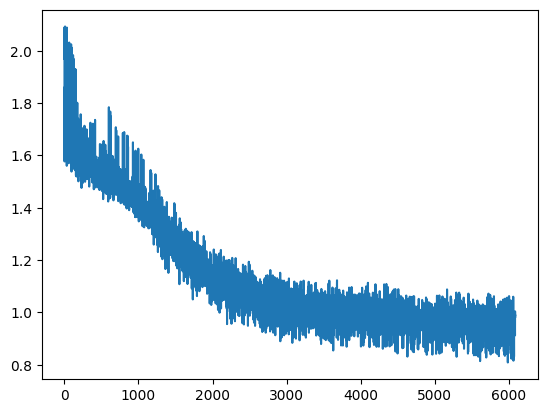

In [106]:
import matplotlib.pyplot as plt

plt.plot(np.arange(len(training_logs["loss"])), training_logs["loss"])

In [107]:
test_data_source = {}
test_data_target = {}
test_data_conditions = {}
adata_test = sc.read("/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_test.h5ad")
source = adata_test[adata_test.obs["condition"] == "control"].obsm["X_pca"]
for cond in adata_test.obs["condition"].cat.categories:
    if cond == "control":
        continue
    target = adata_test[adata_test.obs["condition"] == cond].obsm["X_pca"]
    condition_1 = adata_test[adata_test.obs["condition"] == cond].obsm["ecfp_drug_1"]
    condition_2 = adata_test[adata_test.obs["condition"] == cond].obsm["ecfp_drug_2"]
    assert np.all(np.all(condition_1 == condition_1[0], axis=1))
    assert np.all(np.all(condition_2 == condition_2[0], axis=1))
    expanded_arr = np.expand_dims(
        np.concatenate((condition_1[0, :][None, :], condition_2[0, :][None, :]), axis=0), axis=0
    )
    conds = np.tile(expanded_arr, (len(source), 1, 1))
    test_data_source[cond] = source
    test_data_target[cond] = target
    test_data_conditions[cond] = conds

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [111]:
test_data_source_tiled = jax.tree_util.tree_map(lambda x: jnp.tile(jnp.expand_dims(x, 1), (1, 2, 1)), test_data_source)

In [112]:
predicted_target_test = jax.tree_util.tree_map(model.transport, test_data_source_tiled, test_data_conditions)

In [113]:
from ot_pert.metrics import compute_mean_metrics, compute_metrics_fast

In [114]:
metrics = jax.tree_util.tree_map(compute_metrics_fast, test_data_target, predicted_target_test)

In [116]:
compute_mean_metrics(metrics)

{'r_squared': 0.9505661802227665,
 'e_distance': 1.178403027925843,
 'mmd_distance': 0.01134050096761651}

In [117]:
ood_data_source = {}
ood_data_target = {}
ood_data_conditions = {}
adata_ood = sc.read("/lustre/groups/ml01/workspace/ot_perturbation/data/combosciplex/adata_ood.h5ad")
source = adata_ood[adata_ood.obs["condition"] == "control"].obsm["X_pca"]
for cond in adata_ood.obs["condition"].cat.categories:
    if cond == "control":
        continue
    target = adata_ood[adata_ood.obs["condition"] == cond].obsm["X_pca"]
    condition_1 = adata_ood[adata_ood.obs["condition"] == cond].obsm["ecfp_drug_1"]
    condition_2 = adata_ood[adata_ood.obs["condition"] == cond].obsm["ecfp_drug_2"]
    assert np.all(np.all(condition_1 == condition_1[0], axis=1))
    assert np.all(np.all(condition_2 == condition_2[0], axis=1))
    expanded_arr = np.expand_dims(
        np.concatenate((condition_1[0, :][None, :], condition_2[0, :][None, :]), axis=0), axis=0
    )
    conds = np.tile(expanded_arr, (len(source), 1, 1))
    ood_data_source[cond] = source
    ood_data_target[cond] = target
    ood_data_conditions[cond] = conds

/home/icb/dominik.klein/mambaforge/envs/ot_pert_genot/lib/python3.12/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [118]:
ood_data_source_tiled = jax.tree_util.tree_map(lambda x: jnp.tile(jnp.expand_dims(x, 1), (1, 2, 1)), ood_data_source)

In [119]:
predicted_target_ood = jax.tree_util.tree_map(model.transport, ood_data_source_tiled, ood_data_conditions)

In [120]:
metrics = jax.tree_util.tree_map(compute_metrics_fast, ood_data_target, predicted_target_ood)

In [121]:
compute_mean_metrics(metrics)

{'r_squared': 0.4976348736007222,
 'e_distance': 14.759638180738397,
 'mmd_distance': 0.031664483016373646}